In [1]:
import sys
import random
import string
import math
import matplotlib.pyplot as plt
from bitarray import bitarray
# from hashlib import md5

# Bloom Filter

## Code

In [2]:
def hash_function_generator(num_bits, num_functions):
    '''
    Returns a list of `num_functions` almost-independent hash functions
    Assumes that the input to the hash function has a good __hash__() method defined
    '''
    hash_functions = [None] * num_functions
    for i in range(num_functions):
        random.seed(i)
        mask = random.getrandbits(64)
        hash_functions[i] = lambda x : (hash(x) ^ mask) % num_bits
    return hash_functions

class BloomFilter():
    def __init__(self, num_bits, num_functions):
        self.num_bits = num_bits
        self.num_functions = num_functions
        self.num_ones = 0
        self.bits = bitarray('0' * num_bits)
        self.hash_functions = hash_function_generator(num_bits, num_functions)
    
    def _get_hash_values(self, element):
        '''Returns a list of hash values for the element'''
        return [hash_function(element) for hash_function in self.hash_functions]
    
    def add(self, element):
        '''Adds the element to the Bloom filter'''
        hash_values = self._get_hash_values(element)
        for index in hash_values:
            if self.bits[index] == 0:
                self.num_ones += 1
            self.bits[index] = 1
            
    def set_bits(self, bits):
        self.bits = bits
        
    def union(self, filter2):
        '''
        Returns the approximate union of self with filter2. Both filters must have the same number of bits
        The returned filter will have a number of hash functions equal to that of self
        '''
        assert self.num_bits == filter2.num_bits
        new_filter = BloomFilter(self.num_bits, self.num_functions)
        new_bits = self.bits | filter2.bits
        new_filter.set_bits(new_bits)
        return new_filter
    
    def intersection(self, filter2):
        '''
        Returns the approximate intersection of self with filter2. Both filters must have the same number of bits
        The returned filter will have a number of hash functions equal to that of self
        '''
        assert self.num_bits == filter2.num_bits
        new_filter = BloomFilter(self.num_bits, self.num_functions)
        new_bits = self.bits & filter2.bits
        new_filter.set_bits(new_bits)
        return new_filter
            
    def __contains__(self, element):
        '''Always returns True if the element has been added, but may sometimes return True
        even if the element has not been added'''
        hash_values = self._get_hash_values(element)
        all_relevant_bits_are_one = all(self.bits[index] == 1 for index in hash_values)
        return all_relevant_bits_are_one
    
    def __len__(self):
        '''
        Returns the approximate number of elements in the filter. If all bits are 1,
        it throws an exception.
        '''
        if self.num_ones == self.num_bits:
            raise Exception('All bits are 1. This filter could be arbitrarily large.')
        return int(-(self.num_bits / self.num_functions) * math.log(1 - (self.num_ones / self.num_bits)))
    

## Test cases

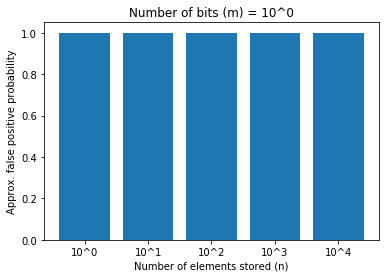

Approx filter size is  0
Approx filter size is  9


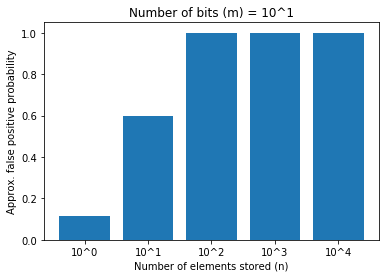

Approx filter size is  0
Approx filter size is  1
Approx filter size is  107


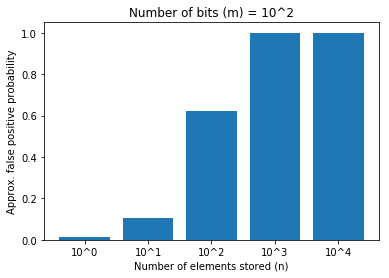

Approx filter size is  0
Approx filter size is  0
Approx filter size is  13
Approx filter size is  975


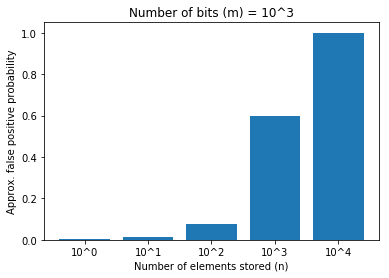

Approx filter size is  0
Approx filter size is  0
Approx filter size is  1
Approx filter size is  143
Approx filter size is  10086


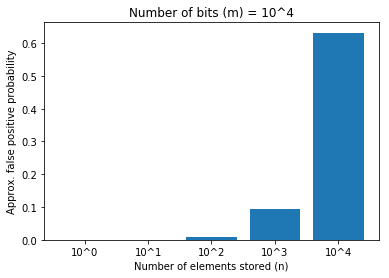

Approx filter size is  0
Approx filter size is  0
Approx filter size is  0
Approx filter size is  14
Approx filter size is  1430


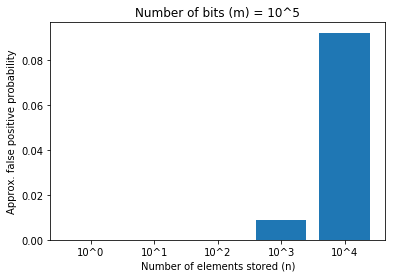

In [3]:
random.seed(0)

orders_of_magnitude_for_n = range(5)
orders_of_magnitude_for_m = range(6)

for j in orders_of_magnitude_for_m:
    false_positive_ratios = []
    m = 10 ** j

    for i in orders_of_magnitude_for_n:
        n = 10 ** i
        k = math.ceil((m / n) * math.log(2))
        bf = BloomFilter(m, k)
        
        # Generating n random numbers as test cases
        ground_truth = set(random.getrandbits(64) for i in range(n))

        # Adding all elements to Bloom filter
        for element in ground_truth:
            bf.add(element)

        # Verifying that there are no false negatives
        for element in ground_truth:
            assert element in bf, f'False negative for element {element}'

        # Estimating the number of false positives
        num_false_positives = 0
        num_elements_not_in_ground_truth = 0
        for i in range(1000):
            random_element = random.getrandbits(64)
            if random_element not in ground_truth:
                num_elements_not_in_ground_truth += 1
                if random_element in bf:
                    num_false_positives += 1
        false_positive_ratios.append(num_false_positives / num_elements_not_in_ground_truth)
        
        try:
            print('Approx filter size is ', len(bf))
        except Exception as e:
            pass

    # Plot bar chart
    x_labels = [f'10^{i}' for i in orders_of_magnitude_for_n]
    plt.bar(orders_of_magnitude_for_n, height=false_positive_ratios)
    plt.xticks(orders_of_magnitude_for_n, x_labels)
    plt.xlabel('Number of elements stored (n)')
    plt.ylabel('Approx. false positive probability')
    plt.title(f'Number of bits (m) = 10^{j}')
    plt.show()

# Spell Checker

## Code

In [4]:
class SpellChecker():
    def __init__(self, path_to_dictionary, false_positive_probability):
        # Calculating optimal parameters for Bloom filter
        with open(path_to_dictionary, 'r', encoding='latin-1') as f:
            num_words = sum(1 for line in f)
        log_prob = math.log(false_positive_probability, 2)
        num_bits = math.ceil(num_words * (-1.44 * log_prob))
        num_hash_functions = math.ceil(-log_prob)
        self.bloom_filter = BloomFilter(num_bits, num_hash_functions)
        print(f'Initialized a Bloom filter with {num_bits} bits and {num_hash_functions} hash functions')
            
        # Adding words to the Bloom filter
        with open(path_to_dictionary, 'r', encoding='latin-1') as f:
            for word in f:
                word = word.rstrip()
                self.bloom_filter.add(word)
                
    def exists(self, word):
        return word in self.bloom_filter
    
    def add_word(self, word):
        self.bloom_filter.add(word)

## Test cases

In [6]:
random.seed(0)

sc = SpellChecker('./wordlist.txt', 0.001)

# Load the set of ground truth words
with open('./wordlist.txt', 'r', encoding='latin-1') as f:
    all_words = set()
    for word in f:
        all_words.add(word.rstrip())
        
# Make sure there are no false negatives
for word in all_words:
    assert sc.exists(word), word

def random_string_generator(length):
    return ''.join(random.choice(string.ascii_uppercase + string.digits) for _ in range(length))

# Estimating the number of false positives
num_false_positives = 0
num_elements_not_in_ground_truth = 0
for i in range(1000):
    random_string = random_string_generator(6)
    if random_string not in all_words:
        num_elements_not_in_ground_truth += 1
        if sc.exists(random_string):
            num_false_positives += 1
print(f'Ratio of false positives is {num_false_positives / num_elements_not_in_ground_truth}')

Initialized a Bloom filter with 4863204 bits and 10 hash functions
Ratio of false positives is 0.068
